# Imports

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import tweepy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from bertopic import BERTopic
from wordcloud import WordCloud
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet

# Project Overview
**Objective:** to conduct an analysis of X(Twitter) accounts that are most frequently flagged by Community Notes, a feature on Twitter allowing the community to add context to tweets they believe are misleading.

* How influential are these accounts in terms of their reach and engagement on Twitter?
* What are their most discussed topics?     

**Data**:    
The data for this analysis is sourced from the Community Notes Leaderboards, which ranks Twitter accounts based on the frequency of being noted. Additionally, we utilize Twitter's API to extract tweets and related metrics from these accounts.

**Analysis Methods**:  
1. Topic modeling using a pre-trained transformer model to identify key themes and subjects in the tweets.
2. Sentiment analysis to get an idea of the overall tone of the content posted by these accounts.

**Purpose**:  as Community Notes highlight incorrect information, this project aims to serve as a brief exploration into the misinformation spread on social media platforms

# Data Collection

## (Selenium)   
Scraping Data for who are top "noted" accounts

In [ ]:
# Initializing the driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

url = "https://community-notes-leaderboard.com/"
def scrape_top_accounts(url, num_accounts=12):
    # Setting up the Selenium driver
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.get(url)

    # Waiting for the page to load dynamically
    driver.implicitly_wait(10)

    accounts = []
    for i in range(1, num_accounts + 2):
        username = driver.find_element(By.CSS_SELECTOR, f"tr:nth-child({i}) .username").text
        url = driver.find_element(By.CSS_SELECTOR, f"tr:nth-child({i}) .handle a").get_attribute('href')
        notes_count = driver.find_element(By.CSS_SELECTOR, f"tr:nth-child({i}) .notes-cell").text

        accounts.append({
            "username": username,
            "url": url,
            "notes_count": notes_count
        })

    # Closing the browser
    driver.quit()

    return accounts

In [ ]:
top_accounts = scrape_top_accounts(url)

In [ ]:
print("Top Accounts:")
for account in top_accounts:
    print(account)

Top Accounts:
{'username': 'CHOQUEI', 'url': 'https://twitter.com/@choquei', 'notes_count': '245'}
{'username': 'Jackson Hinkle', 'url': 'https://twitter.com/@jacksonhinklle', 'notes_count': '235'}
{'username': 'Daily Loud', 'url': 'https://twitter.com/@DailyLoud', 'notes_count': '216'}
{'username': 'Ian Miles Cheong', 'url': 'https://twitter.com/@stillgray', 'notes_count': '178'}
{'username': 'Stew Peters', 'url': 'https://twitter.com/@realstewpeters', 'notes_count': '127'}
{'username': '@Sprinter00000', 'url': 'https://twitter.com/@Sprinter00000', 'notes_count': '123'}
{'username': 'Dom Lucre | Breaker of Narratives', 'url': 'https://twitter.com/@dom_lucre', 'notes_count': '118'}
{'username': 'Dr. Anastasia Maria Loupis', 'url': 'https://twitter.com/@DrLoupis', 'notes_count': '115'}
{'username': 'Mario Nawfal', 'url': 'https://twitter.com/@MarioNawfal', 'notes_count': '113'}
{'username': 'Laughing Man', 'url': 'https://twitter.com/@jhmdrei', 'notes_count': '112'}
{'username': 'Sulaim

In [ ]:
# Dropping the 3 accs as one doesn't seem to exist anymore by the provided URL and the other 2 are not in English
top_accounts = [account for account in top_accounts if account['username'] not in ['@Sprinter00000', 'Laughing Man', 'CHOQUEI']]

## (Tweepy): using X API
Fetching user account and tweet data (texts, metrics).

In [ ]:
bearer_token = "111222333"
client = tweepy.Client(bearer_token)

In [ ]:
def get_account_data(username, notes_count):
    try:
        user = client.get_user(username=username, user_fields=["public_metrics"])
        user_data = user.data
        account_data = {
            "AccountUsername": username,
            "UserID": user_data.id,
            "FollowersCount": user_data.public_metrics["followers_count"],
            "TotalTweetsCount": user_data.public_metrics["tweet_count"],
            "CommunityNotesCount": notes_count
        }
        print(f"Successfully fetched data for {username}")
        return account_data
    except Exception as e:
        print(f"Error fetching data for {username}: {e}")
        return None

In [ ]:
def get_tweets(user_id, username, max_results=100): # fetching 100 last tweets from the accounts
    """
    Fetches tweets for a given user ID.

    Parameters:
    user_id (int): The user ID of the Twitter account.
    username (str): Username of the Twitter account.
    max_results (int): Maximum number of tweets to fetch.

    Returns:
    list: A list of dictionaries, each containing details of a tweet.
    """
    try:
        tweets = client.get_users_tweets(id=user_id, max_results=max_results, tweet_fields=["created_at", "public_metrics"])
        tweet_data = []

        for tweet in tweets.data:
            tweet_data.append({
                "TweetID": tweet.id,
                "AccountUsername": username,
                "TweetText": tweet.text,
                "TweetDate": tweet.created_at,
                "Retweets": tweet.public_metrics['retweet_count'],
                "Likes": tweet.public_metrics['like_count']
            })
        return tweet_data
    except Exception as e:
        print(f"Error fetching tweets for {username}: {e}")
        return []

In [ ]:
combined_data = {"AccountData": [], "TweetData": []}

for account in top_accounts:
    handle = account["url"].split('/')[-1].replace('@', '') # Extracting Twitter handle from the URL and removing the '@' symbol
    notes_count = int(account["notes_count"])
    account_data = get_account_data(handle, notes_count)

    if account_data:
        user_id = account_data["UserID"]
        tweet_data = get_tweets(user_id, handle)

        combined_data["AccountData"].append(account_data)
        combined_data["TweetData"].extend(tweet_data)

Successfully fetched data for iluminatibot
Successfully fetched data for jacksonhinklle
Successfully fetched data for DailyLoud
Successfully fetched data for stillgray
Successfully fetched data for realstewpeters
Successfully fetched data for dom_lucre
Successfully fetched data for DrLoupis
Successfully fetched data for MarioNawfal
Successfully fetched data for ShaykhSulaiman
Successfully fetched data for LauraLoomer


In [ ]:
account_df = pd.DataFrame(combined_data["AccountData"])
tweet_df = pd.DataFrame(combined_data["TweetData"])

## DataFrames    
Displaying the collected data.

In [ ]:
display(account_df.head(10))

,AccountUsername,UserID,FollowersCount,TotalTweetsCount,CommunityNotesCount
0,iluminatibot,3376321847,1577723,132580,246
1,jacksonhinklle,1151913018936053760,2391716,15318,235
2,DailyLoud,452540168,2779186,95258,216
3,stillgray,16106584,881692,457367,178
4,realstewpeters,1288319695658135552,519199,16195,127
5,dom_lucre,3096147528,971705,20551,118
6,DrLoupis,1446231057259433988,1139510,26637,115
7,MarioNawfal,1319287761048723458,1223980,21133,113
8,ShaykhSulaiman,1291128494,336537,13138,111
9,LauraLoomer,537709549,761131,56844,106


In [ ]:
display(tweet_df.head())

,TweetID,AccountUsername,TweetText,TweetDate,Retweets,Likes
0,1743727894881251762,iluminatibot,What if I told you David Icke was right?,2024-01-06 20:15:01+00:00,12,85
1,1743724167394926746,iluminatibot,https://t.co/5oBmynr6Sd,2024-01-06 20:00:12+00:00,32,134
2,1743720344135819379,iluminatibot,Things will escalate very quickly now.,2024-01-06 19:45:01+00:00,177,1293
3,1743716622508994997,iluminatibot,https://t.co/PajnHCoxob,2024-01-06 19:30:14+00:00,55,145
4,1743712793822400835,iluminatibot,"When I say ""netflix and chill"" I mean ""netflix...",2024-01-06 19:15:01+00:00,77,627


# Users Engagement with the Top Noted Accounts    
In this chapter, we briefly examine the readers engagement with the Twitter accounts. Average retweets, likes, and follower counts are plotted to observe engagement levels.

In [ ]:
account_df['FollowersCount'] = account_df['FollowersCount'] / 1000 # to represent the numbers in thousands

In [ ]:
tweet_averages = tweet_df.groupby('AccountUsername')[['Retweets', 'Likes']].mean().reset_index()

In [ ]:
merged_df = pd.merge(account_df, tweet_averages, on='AccountUsername')

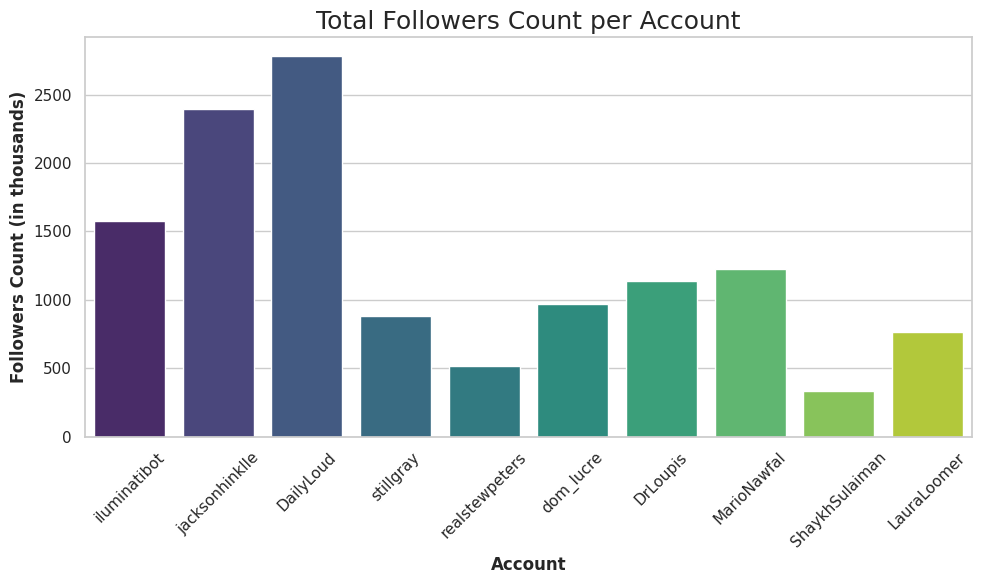

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='AccountUsername', y='FollowersCount', data=account_df, palette="viridis")
plt.xlabel('Account', fontweight='bold', fontsize=12)
plt.ylabel('Followers Count (in thousands)', fontweight='bold', fontsize=12)
plt.title('Total Followers Count per Account', fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

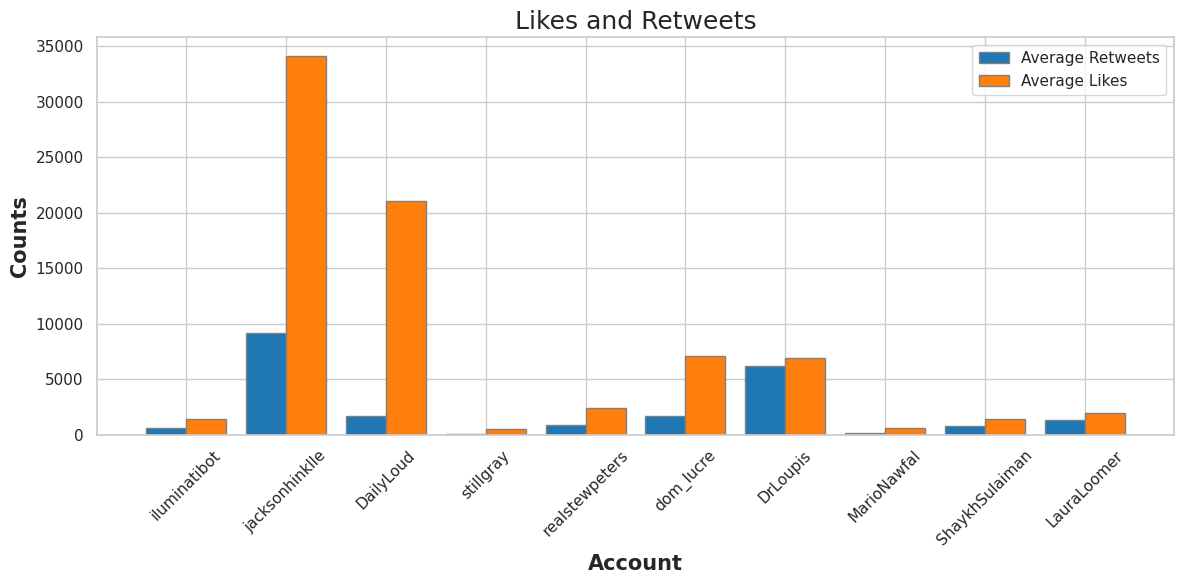

In [ ]:
plt.figure(figsize=(12, 6))
barWidth = 0.4
r1 = np.arange(len(merged_df['AccountUsername']))
r2 = [x + barWidth for x in r1]
color_retweets = sns.color_palette("tab10")[0]
color_likes = sns.color_palette("tab10")[1]
# Creating the 2 bars
plt.bar(r1, merged_df['Retweets'], color=color_retweets, width=barWidth, edgecolor='grey', label='Average Retweets')
plt.bar(r2, merged_df['Likes'], color=color_likes, width=barWidth, edgecolor='grey', label='Average Likes')

plt.xlabel('Account', fontweight='bold', fontsize=15)
plt.title('Likes and Retweets', fontsize=18)
plt.xticks([r + barWidth / 2 for r in range(len(merged_df['AccountUsername']))], merged_df['AccountUsername'], rotation=45)
plt.ylabel('Counts', fontweight='bold', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()


While some accounts has a large number of followers, this does not uniformly translate to proportionally high averages of retweets and likes.   
Notably, Jackson Hinklle displays absolutely extraordinary engagement, with "like" averages surpassing others by far.

# Topic Modelling    
The goal of this chapter is to identify and visualize the predominant topics among the accounts (recent) tweets using BERTopic.  

We clean the data by removing URLs and accounts mentions, applying tokenization and lemmatization, and filtering out stop words.

In [ ]:
# --- Data Cleaning ----

tokenizer = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

# Converting NLTK's POS tags to the format required by lemmatizer
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

custom_stop_words = ['rt', 'say']
stop_words = set(stopwords.words('english') + custom_stop_words)

def clean_tweet(tweet):
    # Removing URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Removing @mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Tokenizing the tweet
    tokens = tokenizer.tokenize(tweet)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Lemmatizing each token
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]

    # Joining the tokens back into a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

tweet_df['CleanedText'] = tweet_df['TweetText'].apply(clean_tweet)
# Removing empty rows
tweet_df = tweet_df[tweet_df['CleanedText'].str.strip().astype(bool)]

In [ ]:
tweet_list = tweet_df['CleanedText'].tolist()

## Topics   
We will utilize the 'bertweet' embedding model, suitable for analyzing Twitter data.

In [ ]:
vectorizer_model = CountVectorizer()

# Creating the BERTopic model
topic_model = BERTopic(embedding_model="vinai/bertweet-base",
                       vectorizer_model=vectorizer_model,
                       calculate_probabilities=True,
                       verbose=True,
                       n_gram_range=(1, 3))

# Fitting the model and transforming the tweets to topics
topics, probabilities = topic_model.fit_transform(tweet_list)


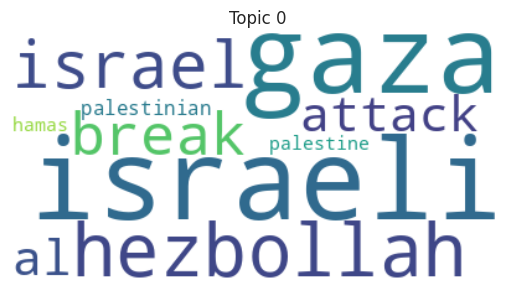

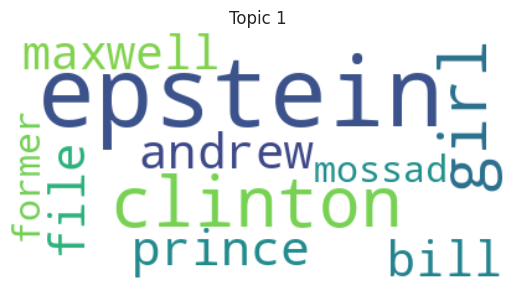

In [ ]:
topic_info = topic_model.get_topic_info()
# Wordcloud for 2 most discussed topics
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic}")
    plt.show()

for i in range(0, 2):
    create_wordcloud(topic_model, topic=i)

# Sentiment    
In this section, we are performing sentiment analysis on the cleaned tweets to understand the overall emotional tone they convey.    


Using the SentimentIntensityAnalyzer from NLTK's VADER, we calculate sentiment scores for each tweet. These scores are then used to classify the tweets into three categories: positive, negative, and neutral.

In [ ]:
sid = SentimentIntensityAnalyzer()

tweet_df['sentiment'] = tweet_df['CleanedText'].apply(lambda x: sid.polarity_scores(x))
tweet_df['compound'] = tweet_df['sentiment'].apply(lambda score_dict: score_dict['compound'])
tweet_df['sentiment_type'] = tweet_df['compound'].apply(lambda c: 'positive' if c > 0 else ('negative' if c < 0 else 'neutral'))

# Counting the number of each type of sentiment
sentiment_counts = tweet_df['sentiment_type'].value_counts()

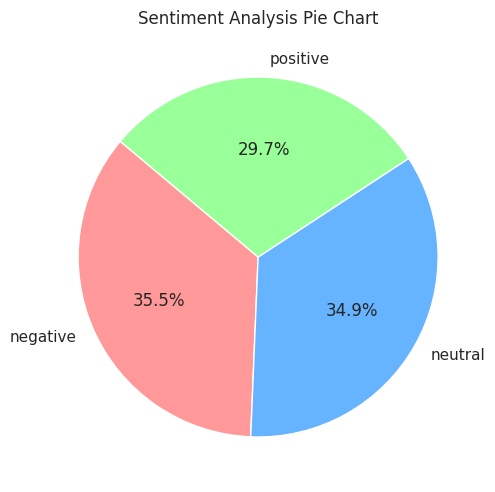

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 2)
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Analysis Pie Chart')
plt.ylabel('')

plt.tight_layout()
plt.show()

The sentiment analysis result indicates a nearly even spread across all sentiment categories, with a slight predominance of negative sentiment at 35.5%.

# Reflections / Future Directions  
Our findings show that the top-flagged by Community Notes accounts discuss sensitive topics the most, lately primarily focusing on the current Middle Eastern war conflict. This raises concerns about the role of social media in information warfare, where accuracy and veracity of shared content are critical.  On top of that, some of the accounts have enormous engagement metrics suggesting big resonance with the audience, which is extra alarming in the context of the potential misinformation spreading. However, a significant limitation of our project is that we didn't analyze the authenticity of these interactions: possible presence of so-called 'bots', which can significantly distort the perception of users engagement.

Another limitation would be the nature of the tweet content in general: many users tend to express opinions and ideas through images rather than text, which our brief analysis could not account for.
A more extensive and dedicated text analysis could also be undertaken in the future, experimenting with more techniques and the models parameters, to compare results in terms of informativeness.
